## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

YFT_PER_PIX = 100/720 # ft per pixel in y dimension
XFT_PER_PIX = 12/600 # ft per pixel in x dimension
MAX_MISSING = 10

def init_consts():
    global YFT_PER_PIX, XFT_PER_PIX, MAX_MISSING
    YFT_PER_PIX = 100/720 # ft per pixel in y dimension
    XFT_PER_PIX = 12/600 # ft per pixel in x dimension

def calibrate_camera(images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)   
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None) 

## Test function calibrate_camera()
* Calibrate the camera using all images in camera_cal directory
* Set MTX, DIST as global constants
* Print the first image to verify the undistortion

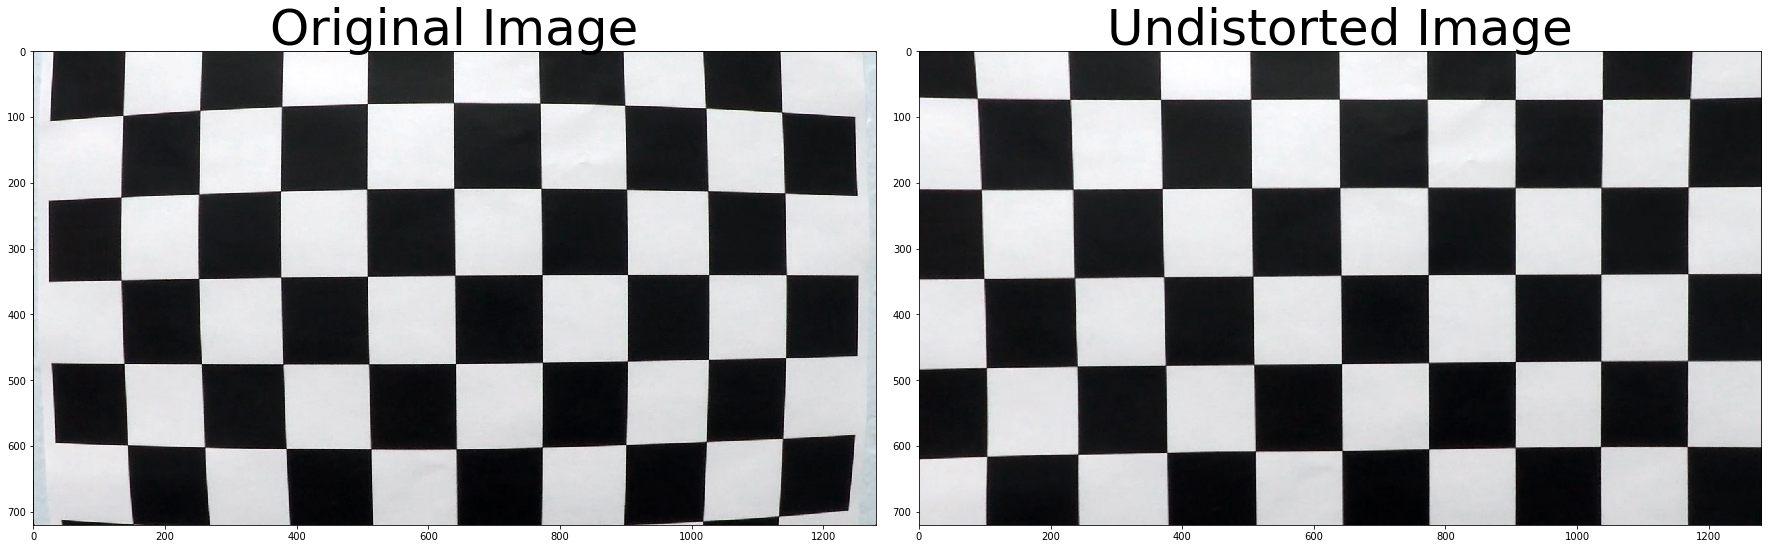

In [2]:
init_consts()
images = glob.glob('./camera_cal/calibration*.jpg')
ret, MTX, DIST, rvecs, tvecs = calibrate_camera(images)

img = cv2.imread(images[0])
undistorted = cv2.undistort(img, MTX, DIST, None, MTX)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Functions to apply combined threshhold

**abs_sobel_thresh**
This function applies threshold to absolute value of either sobelx or sobely

**mag_thresh**
applies threshold to the magnitude of sobelx and sobely value

**dir_thresh**
applies threshold to the absolute value of the gradient direction arctan(sobely/sobelx)

**hls_select**
applies threshold to the S channel of hls color space

**combined_thresh**
combines the results of all selection methods into a final binary value:
* sobelx
* sobely
* magnitude
* direction
* hls space

In [3]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)      
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(sobel_magnitude*255/np.max(sobel_magnitude)) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled > thresh[0]) & (scaled <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir > thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def combined_thresh(image, ksize=3, thresh=(0,255), g_thresh=(0, np.pi/2)):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=thresh)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=thresh)
    dir_binary = dir_thresh(image, sobel_kernel=ksize, thresh=g_thresh)
    s_binary = hls_select(image, thresh=thresh)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
    return combined

## Test combined threshold select
* Read in an image from test_images directory
* Undistort the image and apply threshhold 
* Calibrate the thresh parameters to get a clean image
* Print the orignal image and the image after threshold to verify 

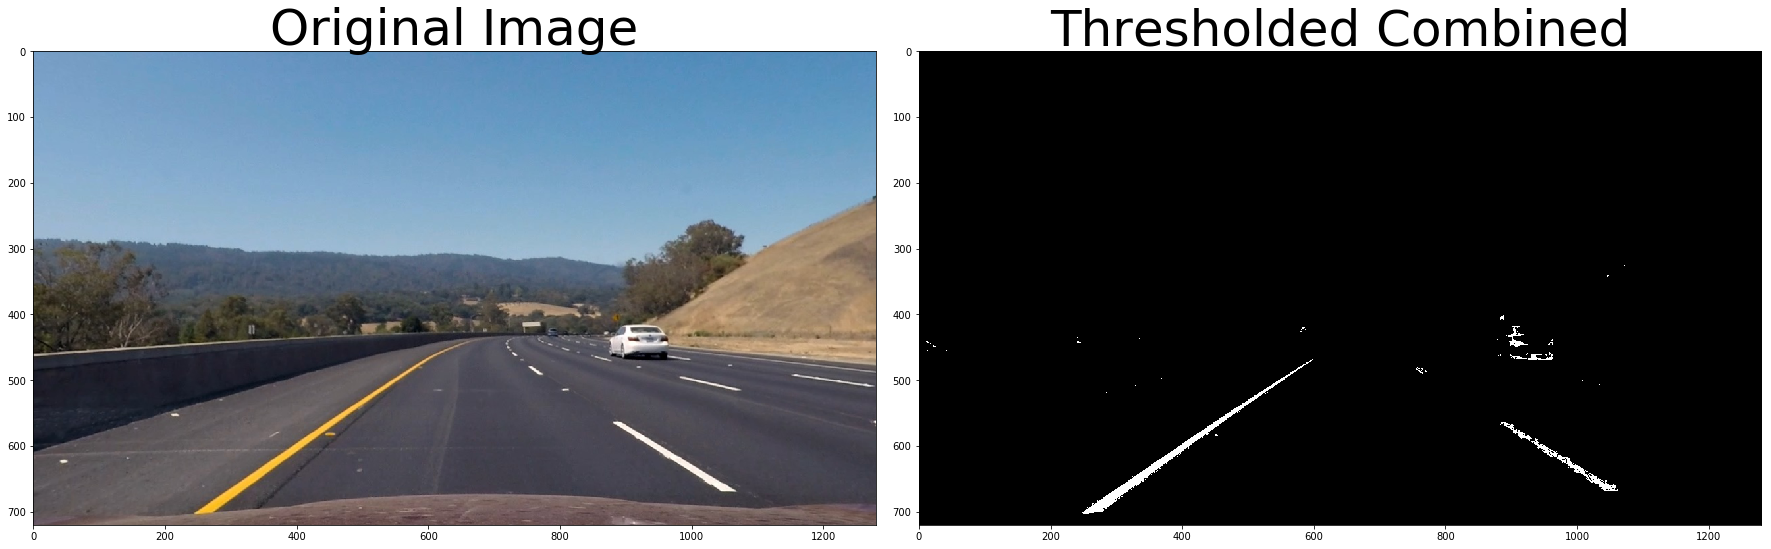

In [4]:
init_consts()
image_path = './test_images/test3.jpg'
image = mpimg.imread(image_path)
image = cv2.undistort(image, MTX, DIST, None, MTX)
binary = combined_thresh(image, ksize=15, thresh=(150, 255), g_thresh=(0.7,1.0))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Thresholded Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Function to perform perspective transformation

In [5]:
def perspective_tranform(img,src, dst):
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped

## Test Perspective Transform
* Apply a distortion correction to raw images.
* Define the source and distination by manually select from the printed image
* Perform transformation
* Print the original image, and the warped image to verify if the bird eye view
* Print dots on the src corners

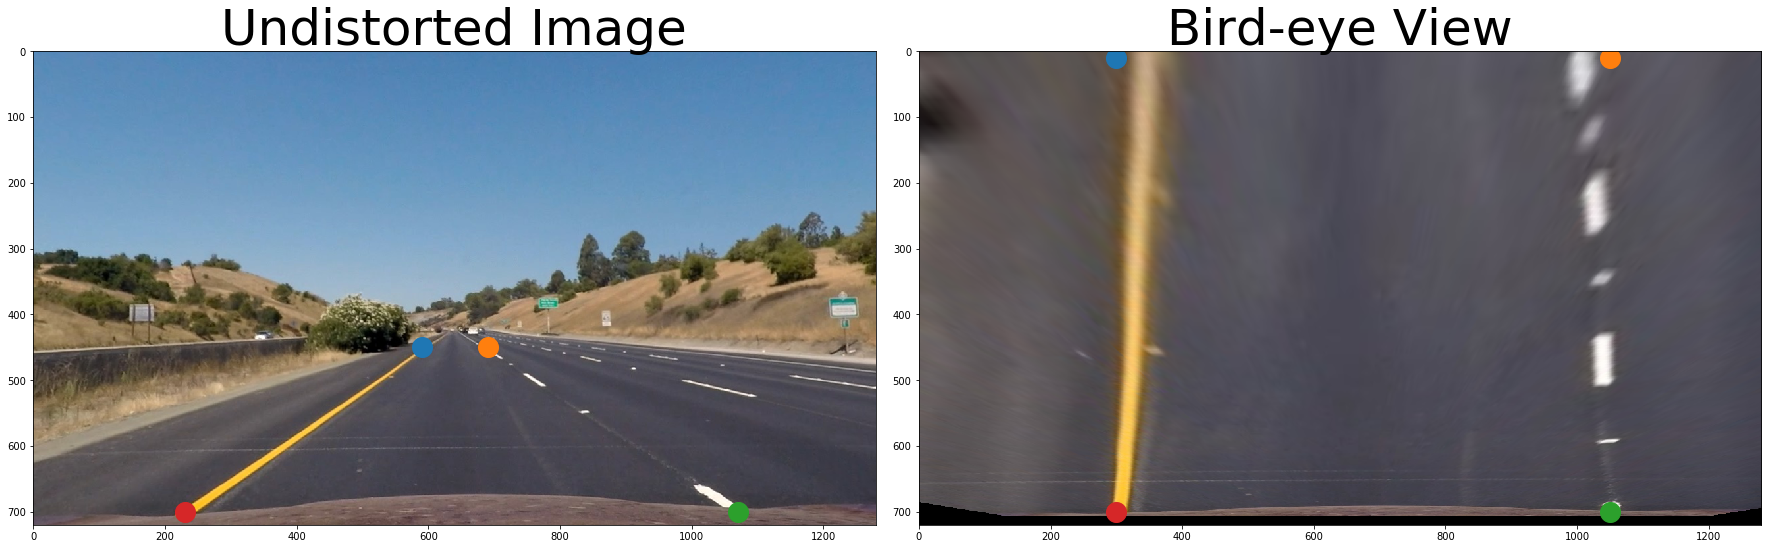

In [6]:
init_consts()
image_path = './test_images/straight_lines1.jpg'
image = mpimg.imread(image_path)
undist = cv2.undistort(image, MTX, DIST, None, MTX)

src = np.float32([
        [590,450],
        [690,450],
        [1070,700],
        [230,700]
    ])
dst = np.float32([
    [300,10],
    [1050,10],
    [1050,700],
    [300,700]
])
warped = perspective_tranform(undist, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=50)
for dot in src:
    ax1.plot(dot[0],dot[1],marker='o',markersize=20)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Bird-eye View', fontsize=50)
for dot in dst:
    ax2.plot(dot[0],dot[1],marker='o',markersize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Define Line class to sanitize and smooth the lines based recent frames
* Assume fit is not valid
* check if there are line detected
* Calculate the fit coefficients of the new x and y
* Check if it's approximately parallel to best fit 
* Check if recorded over n iterations
* remove the first collection of x
* Caculate the best fit of current recorded frames
* Reset the 
* Record this line as missing and check if it ecceeds the tolerance      

In [7]:
class Line():
    def __init__(self,n = 5):
        # number of frames for smoothing
        self.n = n
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = np.linspace(0, 719, 720 )
        # Record consecutive missing frames
        self.num_of_missed = 0
        
    def add(self,linex,liney):
        # Assume fit is not valid
        is_valid_fit = False
        # check if there are line detected
        if len(linex) > 0:
            # Calculate the fit coefficients of the new x and y
            fit = np.polyfit(liney, linex, 2)
            # Check if it's approximately parallel to best fit 
            is_valid_fit = self.sanitize(fit)
            if is_valid_fit == True:
                self.detected = True
                self.allx = self.setallx(fit)
                self.diffs = fit - self.current_fit      
                self.current_fit = fit
                self.recent_xfitted.append(self.allx)
                # Check if recorded over n iterations
                if len(self.recent_xfitted) > self.n:
                    # remove the first collection of x
                    self.recent_xfitted.pop(0)
                self.bestx = np.average(self.recent_xfitted, axis=0)  
                # Caculate the best fit of current recorded frames
                self.best_fit = np.polyfit(self.ally, self.bestx,2)
                self.radius_of_curvature = self.calculate_curvatures()
                self.line_base_pos = self.calculate_position()
                # Reset the 
                self.num_of_missed = 0
        # Record this line as missing and check if it ecceeds the tolerance        
        if len(linex) == 0 or is_valid_fit == False:
            self.detected = False   
            self.num_of_missed += 1
            if self.num_of_missed >= 10: self.reset()
            
    def calculate_curvatures(self):
        fit = np.polyfit(self.ally*YFT_PER_PIX, self.bestx*XFT_PER_PIX, 2)
        y_eval = np.max(self.ally)
        curverad = ((1 + (2*fit[0]*y_eval*YFT_PER_PIX + fit[1])**2)**1.5) / np.absolute(2*fit[0])
      
        return curverad   
    
    def calculate_position(self):
        return (1280/2 - (self.best_fit[0]*720**2 + self.best_fit[1]*720 + self.best_fit[2])) * XFT_PER_PIX
    
    def setallx(self, fit):
        ploty = np.linspace(0, 719, num=720 )
        fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        return fitx
    
    def sanitize(self, fit):
        ploty = np.linspace(0, 719, num=720)
        y_eval = np.max(ploty)
        if len(self.recent_xfitted) == 0:
            std = 0
        else:
            std = np.std(self.allx - self.bestx)

        return std < 100
    
    def reset(self):
        self.recent_xfitted = [] 
        self.num_of_missed = 0

## Functions to find lines in a frame

**find_lines()** returns left fit and right fit

* Import global_left_line and global_right_line as global variables
  
* Get a map of x,y

* If both line are detected, use look ahead search based on last frame

* Otherwise use sliding window search to 

* Extract left and right line pixel positions

* Add two lines to the Lines



In [8]:
def sliding_window_search(binary_warped, nwindows=9):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    return left_lane_inds,right_lane_inds

def look_ahead_search(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    return left_lane_inds,right_lane_inds

def find_lines(binary_warped):
    # Import global_left_line and global_right_line as global variables
    global global_left_line
    global global_right_line
    # Get a map of x,y
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    if global_left_line.detected == True and global_right_line.detected == True:
        # If both line are detected, use look ahead search based on last frame
        left_lane_inds, right_lane_inds = look_ahead_search(binary_warped, global_left_line.best_fit, global_right_line.best_fit)
    else:
        # Otherwise use sliding window search to 
        left_lane_inds,right_lane_inds = sliding_window_search(binary_warped, nwindows=9)
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Add two lines to the Lines
    global_right_line.add(rightx, righty)
    global_left_line.add(leftx, lefty)
    
    return global_left_line.best_fit,global_right_line.best_fit

## Visualize lanes found in the wraped image

Find left and right lines and draw the line on the bird-view image

(720, 0)

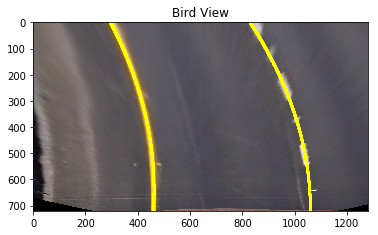

In [9]:
init_consts()
global_left_line = Line()
global_right_line = Line()

image_path = './test_images/test2.jpg'
image = mpimg.imread(image_path)
undist = cv2.undistort(image, MTX, DIST, None, MTX)
binary = combined_thresh(undist, ksize=15, thresh=(80, 255), g_thresh=(0.7,1.0))

src = np.float32([
        [590,450],
        [690,450],
        [1060,700],
        [230,700]
    ])
dst = np.float32([
    [400,0],
    [1000,0],
    [1000,720],
    [400,720]
])

warped = perspective_tranform(binary, src, dst)
warped_undist = perspective_tranform(undist, src, dst)


# Find lines the warped image
left_fit,right_fit  = find_lines(warped)

# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(warped_undist,cmap='gray')
plt.plot(left_fitx, ploty, color='yellow', marker='o',markersize=2)
plt.plot(right_fitx, ploty, color='yellow', marker='o',markersize=2)
plt.title('Bird View')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Function to calculate curvatures

**Reverse the warp process to project the found line back to the original image**

In [10]:
def project_lanes(warped, left_fit, right_fit):
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    return perspective_tranform(color_warp,dst,src)

## Test project_lanes() and visualization

Text(0.5,1,'Projected back to the original image')

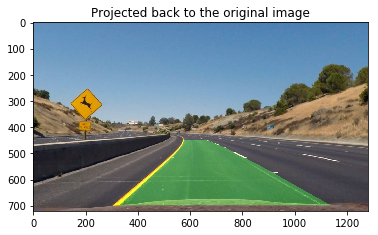

In [11]:
init_consts()
global_left_line = Line()
global_right_line = Line()

image_path = './test_images/test2.jpg'
image = mpimg.imread(image_path)
undist = cv2.undistort(image, MTX, DIST, None, MTX)
binary = combined_thresh(undist, ksize=15, thresh=(80, 255), g_thresh=(0.7,1.0))

src = np.float32([
        [590,450],
        [690,450],
        [1060,700],
        [230,700]
    ])
dst = np.float32([
    [400,0],
    [1000,0],
    [1000,720],
    [400,720]
])

warped = perspective_tranform(binary, src, dst)
warped_undist = perspective_tranform(undist, src, dst)


# Find lines the warped image
left_fit,right_fit = find_lines(warped)

# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
newwarp = project_lanes(warped, left_fit, right_fit)
projected = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(projected)
plt.title('Projected back to the original image')

## Pineline that used to process each image
**The teps of this pipeline are the following:**
* Apply a distortion correction to raw images.

* Use color transforms, gradients, etc., to create a thresholded binary image.

* Apply a perspective transform to rectify binary image ("birds-eye view").

* Get warped bird eye view of the image

* Detect lane pixels and fit to find the lane boundary.

* Determine the curvature of the lane and vehicle position with respect to center.

* Warp the detected lane boundaries back onto the original image.

* add current Curve radius and distance off center to the frame

* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [12]:
def process_image(img):
    global global_left_line
    global global_right_line
    # Apply a distortion correction to raw images.
    undist = cv2.undistort(img, MTX, DIST, None, MTX)
    # Use color transforms, gradients, etc., to create a thresholded binary image.
    thresholded_binary = combined_thresh(undist, ksize=15, thresh=(100, 255), g_thresh=(0.7,1.0))
    # Apply a perspective transform to rectify binary image ("birds-eye view").
    src = np.float32([
        [590,450],
        [690,450],
        [1060,700],
        [230,700]
    ])
    dst = np.float32([
        [400,0],
        [1000,0],
        [1000,720],
        [400,720]
    ])
    # Get warped bird eye view of the image
    warped = perspective_tranform(thresholded_binary, src, dst)
    # Detect lane pixels and fit to find the lane boundary.
    left_fit,right_fit = find_lines(warped)
    # Determine the curvature of the lane and vehicle position with respect to center.
    ave_curve = (global_left_line.radius_of_curvature + global_right_line.radius_of_curvature) / 2
    distance = (global_left_line.line_base_pos + global_right_line.line_base_pos) / 2
    # Warp the detected lane boundaries back onto the original image.
    newwarp = project_lanes(warped, left_fit, right_fit)
    projected = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # add current Curve radius and distance off center to the frame
    text = 'Curve radius: ' + '{:04.2f}'.format(ave_curve) + 'ft'
    cv2.putText(projected, text, (40,70), 1, 3, (200,255,155), 2, cv2.LINE_AA)
    if distance >= 0: 
        direction = 'right' 
    else: 
        direction = 'left'
    text = 'Vehicle is ' + '{:04.2f}'.format(np.absolute(distance)) +' ft to the '+direction+' of the center'
    cv2.putText(projected, text, (40,120), 1, 3, (200,255,155), 2, cv2.LINE_AA)
    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    return projected

# Test process image and put result in output_image directory

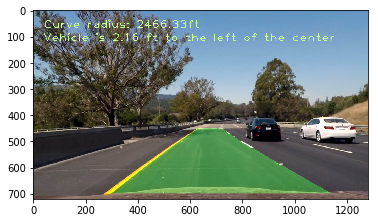

In [13]:
init_consts()
global_left_line = Line()
global_right_line =  Line()
imgs = glob.glob('./test_images/*.jpg')
for img in imgs:
    global_left_line.reset()
    global_right_line.reset()
    # Read in and grayscale the image
    fileName = img.split('/')[-1]
    image = mpimg.imread("test_images/"+fileName)
    processed_image = process_image(image)
    plt.imshow(processed_image)
    plt.savefig("./output_image/"+fileName)  

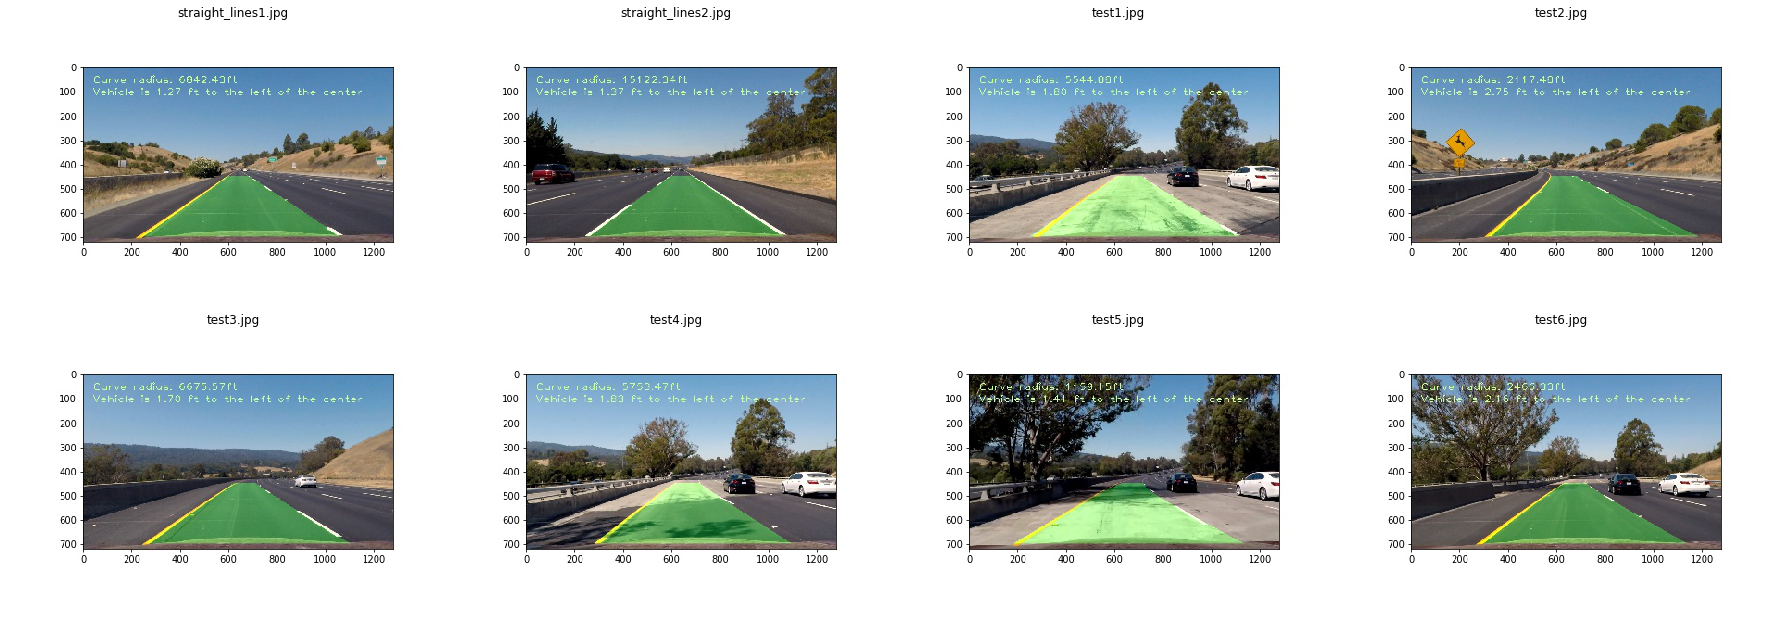

In [14]:
imgs = glob.glob('./output_image/*.jpg')
f, axes = plt.subplots(2, 4, figsize=(24, 9))
axes = axes.ravel()
f.tight_layout()

for key,ax in enumerate(axes):
    image = mpimg.imread(imgs[key])
    ax.axis('off')
    ax.imshow(image)
    ax.set_title(imgs[key].split('/')[-1])
f.savefig("./output_image/test_images.png")    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

## Test on video

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
init_consts()
global_left_line = Line(25)
global_right_line =  Line(25)
white_output = 'output_video/project_video.mp4'
clip1 = VideoFileClip("video/project_video.mp4")
# clip1 = VideoFileClip("video/project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████▉| 1260/1261 [05:02<00:00,  4.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

CPU times: user 5min 42s, sys: 58.6 s, total: 6min 40s
Wall time: 5min 3s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [18]:
# white_output = 'output_video/challenge_video.mp4'
# clip1 = VideoFileClip("video/challenge_video.mp4").subclip(0,5)
# white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(white_output, audio=False)

In [19]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(white_output))

In [20]:
# white_output = 'output_video/harder_challenge_video.mp4'
# clip1 = VideoFileClip("video/harder_challenge_video.mp4").subclip(0,10)
# white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(white_output, audio=False)

In [21]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(white_output))